# 04. PyTorch Custom Datasets

## 0. Import PyTorch and setup device-agnostic code

In [ ]:
import copy

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

torch.__version__

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


^^## 1. Get data
For this module we will use the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/). It encompasses 101 classes of 
distinct foods and 1000 images per class which makes a total of 101.000 images (75% train, 25% test).

Machine learning is an iterative process: start small, get something working, and increase when necessary. We will start with only three classes of 
the dataset (steak, sushi and pizza) and instead of 1000 images per class only a random 10%.

For starters, we will also use the pre-formated dataset from the course.

In [ ]:
# Load pre-formated dataset
import requests
import zipfile
from pathlib import Path

data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print(f"{image_path} directory already exists")
else:
    print(f"Did not find {image_path} directory. Creating new one")
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)
        
    with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
        print('Unzipping pizza, steak, sushi data...')
        zip_ref.extractall(image_path)
        print('Donwload complete')

## 2. Become one with the data (data preparation)

Before starting a project or building any kind of model, it's important to know what data you're working with.

In our case, we have images of pizza, steak and sushi in standard image classification format.

Image classification format contains separate classes of images in separate directories titled with a particular class name.

For example, all images of pizza are contained in the pizza/ directory.

This format is popular across many different image classification benchmarks, including ImageNet (of the most popular computer vision benchmark datasets).

This is what the directory structure looks like:


```pizza_steak_sushi/ <- overall dataset folder
    train/ <- training images
        pizza/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image24.jpeg
            image25.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- testing images
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image154.jpeg
            image155.jpeg
            ...
        sushi/
            image167.jpeg
            ...
```

The goal will be to take this data storage structure and turn it into a dataset usable with PyTorch.


We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.

To do so, we'll use Python's in-built `os.walk()`.

In [ ]:
import os

def walk_through_dir(dir_path):
    for dir_path, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dir_path}")

In [ ]:
walk_through_dir(image_path)

Excellent! It looks like we have got 100 images per class, 75 for training and 25 for testing.

In [ ]:
# Setup training and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'
print(train_dir)
print(test_dir)

### 2.1 Visualize images
1. Get all of the image paths using pathlib.Path.glob() to find all of the files ending in .jpg.
2. Pick a random image path using Python's random.choice().
3. Get the image class name using pathlib.Path.parent.stem.
4. And since we're working with images, we'll open the random image path using PIL.Image.open() (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.

In [ ]:
import random
from PIL import Image

random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path : Path = random.choice(image_path_list)
image_class  = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

We can achieve the same with `matplotlib.pyplot.imshow()` but we first have to convert the image to a NumPy array.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_array)
plt.title(f"Image class: {image_class} | Image shape in HWC format: {img_array.shape}")
plt.axis(False)

## 3. Transforming data
How do we load the image data into PyTorch?

1. Turn it into a tensor
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`.

Torch has support for some common DL problems like vision , audio, text and recommender systems. We will use `torchvision.datasets` for our 
data loading functions and 
`torchvision.transforms for preparing our data.

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming the data
The first step is to transform the folders of images to tensors.

To get experience with `torchvision.transforms`, let's write a series of transform steps that:

1. Resize the images using `transforms.Resize()` (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).
2. Flip our images randomly on the horizontal using `transforms.RandomHorizontalFlip()` (this could be considered a form of data augmentation because 
it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using `transforms.ToTensor()`.

We can compile all of these steps using `torchvision.transforms.Compose()`.

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

Let's try out the transform on random images and plot them.

In [ ]:
from typing import List, Optional


def plot_transformed_images(image_paths: List[Path], transform: transforms.ToTensor, n: int=3, seed: Optional[int] = 42):
    random.seed(seed)
    random_img_paths: List[Path] = random.sample(image_paths, k=n)
    for img_path in random_img_paths:
        with Image.open(img_path) as img:
            fig, ax = plt.subplots(1, 2)
            # Plot original image in first column
            ax[0].imshow(img)
            ax[0].set_title(f"Original\nSize: {img.size}")
            ax[0].axis(False)
            
            # Plot transformed image in second column
            transformed_img = transform(img).permute(1, 2, 0).numpy()   # PyTorch default image format is CHW, PyPlot needs HWC
            ax[1].imshow(transformed_img)
            ax[1].set_title(f"Transformed\nSize: {transformed_img.shape}")
            ax[1].axis(False)
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

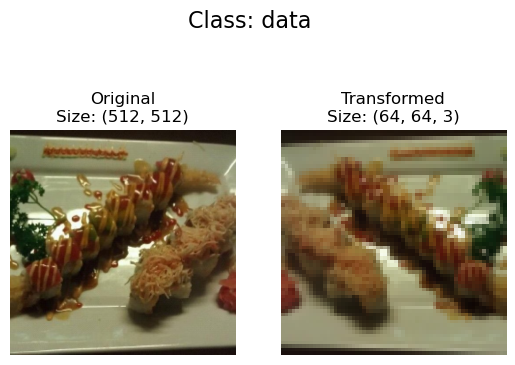

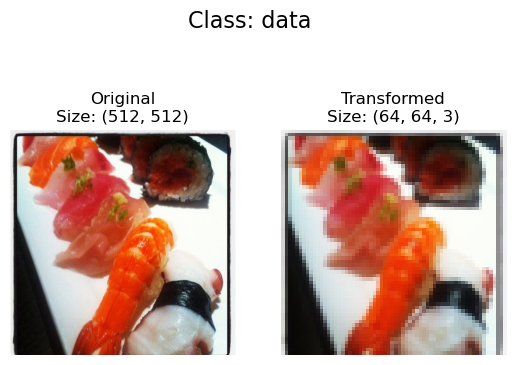

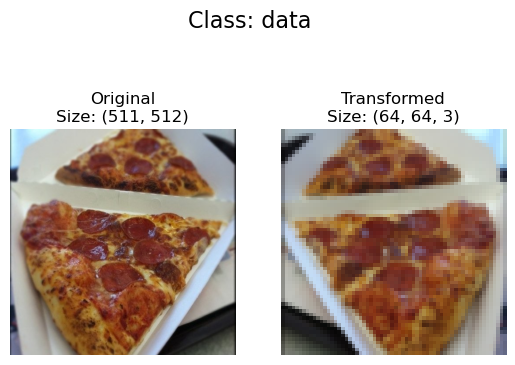

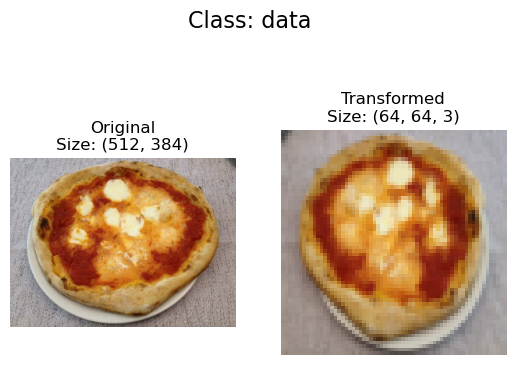

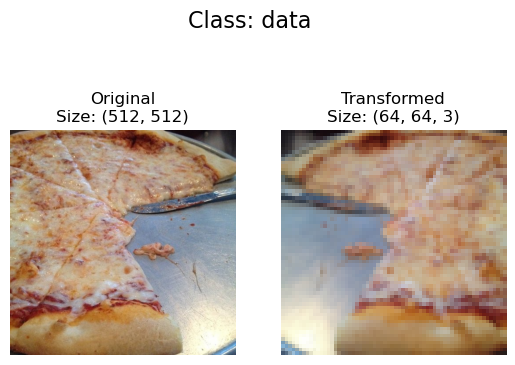

In [12]:
plot_transformed_images(image_path_list, data_transform, 5)

## 4. Option 1: Loading Image Data Using `Image Folder`
Now we need to turn out data into a `Dateset` so that it can be used with built-in PyTorch functionalities. Since our data is structured in the 
standard image classification format, we can use the `ImageFolder` class. It takes in a path to the data target directory and converts it into a 
`Dataset` and allows for transformations via the `transform`parameter. Let's turn our `train`_dir` and `test_dir` into datasets.

In [13]:
from torchvision import datasets

train_data = datasets.ImageFolder(train_dir, data_transform)
test_data = datasets.ImageFolder(test_dir, data_transform)

print(f"Train data:\n{train_data}\n\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


It looks like PyTorch has registered our datasets. Let's check by calling the `classes` and `classes_to_idx` attributes.

In [14]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
len(train_data), len(test_data)

(225, 75)

We can index our datasets to find specific images and their labels.

In [17]:
img, label = train_data[0][0], train_data[0][1]

print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

### 4.1 Turn loaded images into `DataLoader`s
To keep things simple we will use`batch_size=1` and `num_workers=1`. `num_workers` specifies how many subprocesses will be created to load the data
. You can use Python's `os.cpu_count()` to match it with the number of CPUs in your machine.

In [18]:
train_dataloader = DataLoader(dataset=train_data, batch_size=1, num_workers=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=1, num_workers=1, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ff2a7fd3cd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff2cd490c10>)

Now our data is iterable. Let's quickly check the shapes.

In [19]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


The image has shape `[1, 3, 64, 64]` because the dataloader does not load individual images but batches that contain only one images.

Before we dive into training we'll look at another way to load custom data that works for almost any kind of data.

## 5. Option 2: Loading Image Data with a Custom `Dataset`
What if no prebuilt `Dataset` creator like `torchvision.datasets.ImageFolder` exists for your specific problem? Then we can simply build our own.

In [20]:
import os   # for dealing with directories
import pathlib  # for dealing with filepaths
import torch

from PIL import Image   # class for loading images from filepaths
from torch.utils.data import Dataset
from torchvision import transforms

With our custom `Dataset` class we want to replicate the following two attributes:

In [21]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names
Let's write a helper function capable of creating a list of class names and a dictionary associating the class names with their indices.

In [22]:
from typing import Tuple, Dict, List


def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """
    Find class folder names in the target directory.
    
    Assumes that tha target directory is in standard image classification format.
    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    
    # 1. Get sorted class names by scanning the directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if the class names are not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")
    
    # 3. Create a dictionary of index labels
    class_to_idx = {name: idx for idx, name in enumerate(classes)}
    return classes, class_to_idx

Let's test out our helper function.

In [23]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

Looking good.

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`
Let's break it down:
1. Subclass `torch.utils.data.Dataset`
2. Initialize our subclass with `target_dir` and an optional`transform` parameter
3. Create attributes `paths` (path for target images), `transform`, `classes` and `class_to_idx`
4. Create a function to load an image from its file and return (for this we can use `PIL.Image` or `torchvision.io` for input/output of vision data)
5. Optionally overwrite `__len__()` allowing use to cal `len(Dataset)`.
6. Overwrite `__getitem__()`to get a single image, this is required.

In [24]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
    def __init__(self, target_dir: str, transform=None) -> None:
        self.paths = list(pathlib.Path(target_dir).glob('*/*.jpg'))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_dir)
       
    def load_image(self, index: int) -> Image.Image:
        return Image.open(self.paths[index])
        
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx 

Later we could move this custom dataset class to a `data_loader.py` file alongside other helper functions for data and reuse it later.

Before we test our new class we will create some transforms to prepare our images

In [25]:
# Augment training data
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Simply reshape test data, don't augment
test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

Let's try to turn our images in our train and test directories into `Dataset`s using our custom `Dataset` class.

In [26]:
train_data = ImageFolderCustom(train_dir, train_transform)
test_data = ImageFolderCustom(test_dir, test_transform)

train_data, test_data

(<__main__.ImageFolderCustom at 0x7ff2a7b97760>,
 <__main__.ImageFolderCustom at 0x7ff2a7d5be80>)

In [27]:
len(train_data), len(test_data)

(225, 75)

In [28]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

Looks good. Now let's quickly write a function to plot random images to test our `__getitem__()` method.

### 5.3 Create a function to displays random images

In [29]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

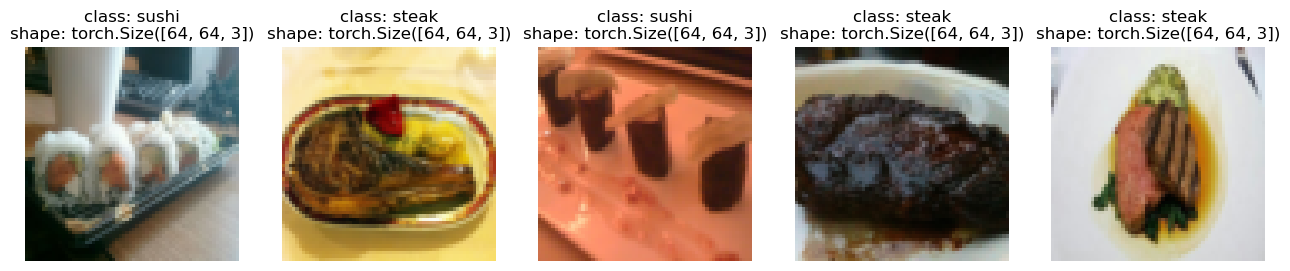

In [30]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `DataLoader`s

In [31]:
train_dataloader = DataLoader(dataset=train_data, batch_size=1, num_workers=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=1, num_workers=1, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ff2a7c875e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff38f72f580>)

In [32]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape}")
print(f"Image dtype: {img.dtype}")
print(f"Label shape: {label.shape}")
print(f"Label dtype: {label.dtype}")

Image shape: torch.Size([1, 3, 64, 64])
Image dtype: torch.float32
Label shape: torch.Size([1])
Label dtype: torch.int64


## 6. Other Transforms
Transforms can be useful for **data augmentation** which is the process of copying some of the samples and altering them slightly to artificially 
increase the diversity of the training data with the aim of improving the generalization of the models.

Research shows that using random transforms like `transforms.RandAugment()` or `transforms.TrivialAugmentWide()` generally perform better than 
handpicked transforms.

The main parameter to pay attention to with `transforms.TrivialAugmentWide()` is `num_magnitude_bins=31` which controls the intensity range for the
 transform.

In [33]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])    

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

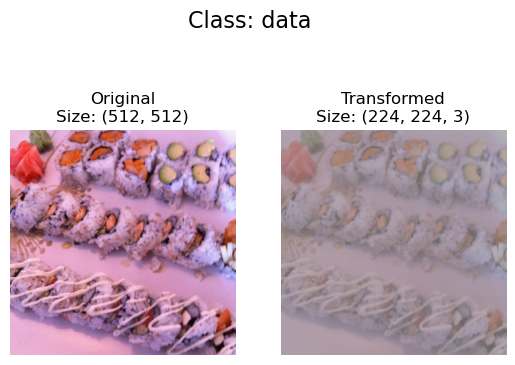

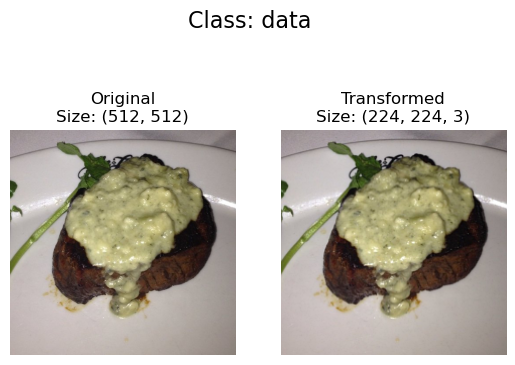

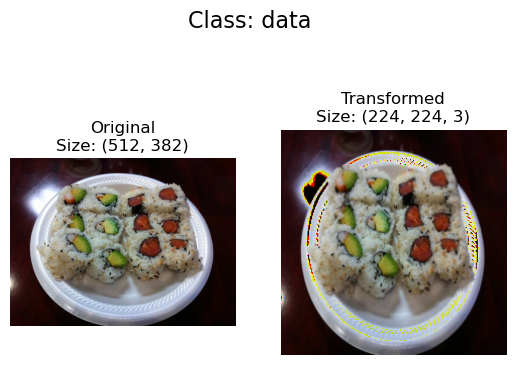

In [34]:
image_path_list = list(image_path.glob('*/*/*.jpg'))

plot_transformed_images(image_paths=image_path_list, transform=train_transform, n=3, seed=None)

## 7. Model 0: TinyVGG without data augmentation
Now that we got all helper functions for the data set up, we can start training our computer vision image classifier. To see what impact data 
augmentation has on generalization (here, performance on the test set), we will first train the model on the original data and then retrain the 
model on the augmented training data.

### 7.1 Creating transforms and loading data for Model 0
Let's define a simple transform that resizes the image to 64 pixels in height and width and turns the images into tensors.

In [35]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

Now, let's turn our folders with the image data (`train_dir` and `test_dir`) first into instances of our custom `Dataset` and then turn them into 
`DataLoader`s.

In [36]:
simple_train_data = ImageFolderCustom(target_dir=train_dir, transform=simple_transform)
simple_test_data = ImageFolderCustom(target_dir=test_dir, transform=simple_transform)

simple_train_dataloader = DataLoader(dataset=simple_train_data, batch_size=32, shuffle=True, num_workers=os.cpu_count())
simple_test_dataloader = DataLoader(dataset=simple_test_data, batch_size=32, shuffle=False, num_workers=os.cpu_count())

simple_train_dataloader, simple_test_dataloader, os.cpu_count()

(<torch.utils.data.dataloader.DataLoader at 0x7ff2a7326b90>,
 1)

### 7.2 Create TinyVGG model class
Now we will build a model to classify our images. We will go with the TinyVGG architecture from the previous chapter. It is a CNN and did pretty 
well on the MNIST datasets.

In [37]:
from torch import nn

class Conv2dBlock(nn.Module):
    def __init__(self, in_channels: int, hidden_units: int, out_channels: int):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.conv_maxpool_layer = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv_maxpool_layer(self.conv_layer(x))
    


class TinyVGG(nn.Module):
    def __init__(self, in_shape: Tuple[int, int, int], hidden_units: int, out_classes: int, num_blocks: int):
        super().__init__()
        self.num_blocks = num_blocks
        self.block_1 = Conv2dBlock(in_channels=in_shape[0], hidden_units=hidden_units, out_channels=hidden_units)
        self.block_2 = Conv2dBlock(in_channels=hidden_units, hidden_units=hidden_units, out_channels=hidden_units)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=int(hidden_units * (in_shape[1] * in_shape[2] / 4**num_blocks)), out_features=out_classes)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

Here is how we will choose the hyperparameters for the model architecture:
- We want to classify 64x64 pixel images with 3 color channels in CHW format
- We want to use 10 kernels per channel per convolutional layer
- We have to input the number of classes that our dataset has
- We want to use 2 convolutional blocks to classify the images

In [38]:
model_0 = TinyVGG(in_shape=(3, 64, 64), hidden_units=10, out_classes=3, num_blocks=2).to(device)

model_0

TinyVGG(
  (block_1): Conv2dBlock(
    (conv_layer): Sequential(
      (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (conv_maxpool_layer): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (block_2): Conv2dBlock(
    (conv_layer): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (conv_maxpool_layer): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)
Let's test whether we did not make any mistakes when putting the model together and pass a single image through our model.

In [39]:
image, label = simple_train_data[0]
image = image.unsqueeze(dim=0)  # Add dimension so shape fits the model
image.shape

torch.Size([1, 3, 64, 64])

In [40]:
# Forward pass
model_0.eval()
with torch.inference_mode():
    logits: torch.Tensor = model_0(image.to(device))
    probs = logits.softmax(dim=1)
    pred = probs.argmax(dim=1)

print(f"Output logits:\n{logits}\n")
print(f"Prediction probabilities:\n{probs}\n")
print("Prediction:", pred.item(), class_names[pred.item()])
print("Actual class:", label, class_names[label])

Output logits:
tensor([[0.0347, 0.0229, 0.0753]], device='cuda:0')

Prediction probabilities:
tensor([[0.3301, 0.3262, 0.3437]], device='cuda:0')

Prediction: 2 sushi
Actual class: 2 sushi


### 7.4 Use `torchinfo`to get an idea of the shapes going through our model
Instead of using print statements in thr `forward()` method of the model we can use `torchinfo` which comes with a `summary()` method that takes a 
PyTorch model and an `input_shape` as arguments and documents the shapes for each layer and operation in the forward pass.

In [41]:
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

In [42]:
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Conv2dBlock: 1-1                       [1, 10, 32, 32]           --
│    └─Sequential: 2-1                   [1, 10, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 10, 64, 64]           280
│    │    └─ReLU: 3-2                    [1, 10, 64, 64]           --
│    └─Sequential: 2-2                   [1, 10, 32, 32]           --
│    │    └─Conv2d: 3-3                  [1, 10, 64, 64]           910
│    │    └─ReLU: 3-4                    [1, 10, 64, 64]           --
│    │    └─MaxPool2d: 3-5               [1, 10, 32, 32]           --
├─Conv2dBlock: 1-2                       [1, 10, 16, 16]           --
│    └─Sequential: 2-3                   [1, 10, 32, 32]           --
│    │    └─Conv2d: 3-6                  [1, 10, 32, 32]           910
│    │    └─ReLU: 3-7                    [1, 10, 32, 32]           --
│    └─Seque

Skipping subchapters 7.5 and 7.6 since I already functionalized the training-testing loop.

### 7.7 Train and evaluate Model 0

In [43]:
import torch
from torch import nn

loos_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01, momentum=0.9)

In [44]:
from torchmetrics import MetricCollection, MetricTracker, Accuracy, F1Score, AUROC

metrics = MetricCollection({
    'accuracy': Accuracy(task='multiclass', num_classes=len(class_names), average='macro'),
    'f1-score': F1Score(task='multiclass', num_classes=len(class_names), average='macro'),
    'auroc': AUROC(task='multiclass', num_classes=len(class_names), average='macro')
})

train_metric_tracker = MetricTracker(metrics)
test_metric_tracker = copy.deepcopy(train_metric_tracker)

In [45]:
from helper_functions import train_test_loop
from timeit import default_timer as timer

start_time = timer()

train_losses, test_losses, train_metric_tracker, test_metric_tracker = train_test_loop(
    model=model_0,
    loss_fn=loos_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=5,
    device=device,
    train_metric_tracker=train_metric_tracker,
    test_metric_tracker=test_metric_tracker
)

end_time = timer()
train_time = end_time - start_time
print(f"Total training time: {train_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]


EPOCH 1
--------------------------------
--------------------------------
TRAINING EVAL
Loss: 1.1208
Accuracy: 0.2940
Auroc: 0.4484
F1-score: 0.2923
--------------------------------
TEST EVAL
Loss: 1.0820
Accuracy: 0.3333
Auroc: 0.5000
F1-score: 0.1950

EPOCH 2
--------------------------------
--------------------------------
TRAINING EVAL
Loss: 1.1195
Accuracy: 0.2684
Auroc: 0.4498
F1-score: 0.2654
--------------------------------
TEST EVAL
Loss: 1.1325
Accuracy: 0.3333
Auroc: 0.5000
F1-score: 0.1348

EPOCH 3
--------------------------------
--------------------------------
TRAINING EVAL
Loss: 1.1126
Accuracy: 0.3340
Auroc: 0.4778
F1-score: 0.3165
--------------------------------
TEST EVAL
Loss: 1.0990
Accuracy: 0.3333
Auroc: 0.5000
F1-score: 0.1667

EPOCH 4
--------------------------------
--------------------------------
TRAINING EVAL
Loss: 1.1174
Accuracy: 0.3493
Auroc: 0.4696
F1-score: 0.3379
--------------------------------
TEST EVAL
Loss: 1.1336
Accuracy: 0.3333
Auroc: 0.5000
F

It looks like out model is performing terrible (so is the one of the course creator). That its note an implementation mistake but there is 
something fundamentally wrong with the model.

### 7.8 Plot loss curves of Model 0
Let's create a functio to plot the loss of the model

In [58]:
def plot_loss_curves(train_losses: List[float], test_losses: List[float]):
    
    epochs = range(1, max(len(train_losses), len(test_losses)) +1)
    
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_losses, label="Train loss")
    plt.plot(epochs, test_losses, label="Test loss")
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.xticks(epochs, epochs)
    plt.legend()

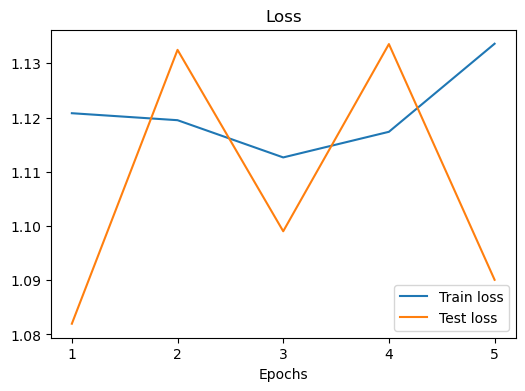

In [59]:
plot_loss_curves(train_losses, test_losses)

In [ ]:
train_metric_tracker.children()

In [60]:
num_metrics = len(metrics)
rows, cols = np.ceil(num_metrics / 2), 2

plt.figure(figsize=(15, 7 * num_metrics))
for i, metric_name in enumerate(metrics.keys()):
    train_metric_values = train_metric_tracker.children()
    test_metric_values = test_metric_tracker.metrics[metric_name].compute().tolist()
    
    plt.subplot(rows, cols, i + 1)
    plt.plot(train_metric_values, label='Train', marker='o')
    plt.plot(test_metric_values, label='Test', marker='o')
    plt.title(f'Metric: {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

AttributeError: 'MetricTracker' object has no attribute 'metrics'

<Figure size 1500x2100 with 0 Axes>